In [1]:
# Topological Initialization for Multidimensional Scaling
# Melinda A. Kleczynski, Anthony J. Kearsley
# Finalized August 26, 2025  

# Data from: https://cave.cs.columbia.edu/repository/COIL-100

In [2]:
# Package versions 
# ----------------
# matplotlib                3.10.5
# numpy                     2.3.2
# oat_python                0.1.1
# pillow                    11.3.0
# scikit-learn              1.7.1
# scipy                     1.16.1

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random 

from PIL import Image
from scipy.spatial.distance import pdist, squareform 
from sklearn.manifold import MDS 

import timds 

In [4]:
def read_image(object_number, image_index):

    fpath = 'coil-100\\obj' + str(object_number) + '__' + str(5*image_index) + '.png'  
    image = np.asarray(Image.open(fpath))   

    return image/np.max(image) 

In [5]:
n_images = 72

In [6]:
# images ordered by ground truth angle; shuffle to hide ground truth 
shuffled_image_indices = [i for i in range(n_images)] 
random.seed(0) 
random.shuffle(shuffled_image_indices) 

In [7]:
object_number = 73
example_name = 'Cheeseburger'
metric = 'cosine'

In [8]:
images = [read_image(object_number, index) for index in shuffled_image_indices] 
image_data = np.vstack([image.flatten() for image in images]) 
image_pdist = squareform(pdist(image_data, metric = metric))

top_init_coords, bc1, cycle_diameter = timds.get_top(image_pdist)
bc1 = bc1.sort_values(by = 'birth', ignore_index = True) 

In [9]:
# random initializations 

m = n_images*(n_images-1)/2 
S = np.sum(np.square(image_pdist))/2  
sigma = (S/(4*m))**0.5

def get_random_init(seed = None):

    rng = np.random.default_rng(seed = seed)
    random_vals = rng.normal(size = (n_images, 2))
    random_init = sigma*random_vals
    return random_init 

In [10]:
# run mds  
mds_alg = MDS(n_components = 2, dissimilarity = 'precomputed', 
              n_init = 1, max_iter = 1000, eps = 1e-6)
mds_coords = mds_alg.fit_transform(image_pdist, init = get_random_init(0))
mds_alg.stress_, mds_alg.n_iter_

(np.float64(0.043002117902530224), 50)

In [11]:
xs = mds_coords[:, 0]
ys = mds_coords[:, 1]

In [12]:
mds_pdist = squareform(pdist(mds_coords, metric = 'euclidean'))
mds_mpc, mds_ph1 = timds.get_mpc_edges(mds_pdist)
mds_bc1 = mds_ph1[['birth', 'death']]
mds_bc1 = mds_bc1.sort_values(by = 'birth', ignore_index = True) 

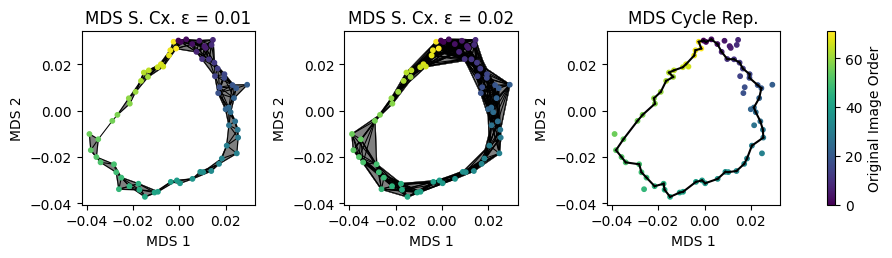

In [13]:
# plot simplicial complexes and cycle representative 

epsilons = [0.01, 0.02]

fig, ax = plt.subplots(1, 3, figsize = (12, 2.25))  

for p in range(3): 

    if p < 2:

        # plot triangles    
        for i in range(n_images):
            for j in range(i):
                for k in range(j): 
                    e1 = mds_pdist[i, j]
                    e2 = mds_pdist[i, k]
                    e3 = mds_pdist[j, k] 
                    if max(e1, e2, e3) <= epsilons[p]: 
                        ax[p].fill(xs[[i, j, k]], ys[[i, j, k]], color = 'gray', zorder = 0) 

        # plot edges
        for i in range(n_images):
            for j in range(i):
                if mds_pdist[i, j] <= epsilons[p]: 
                    ax[p].plot(xs[[i, j]], ys[[i, j]], color = 'k', zorder = 1, lw = 0.75) 

    # plot vertices 
    cbar_plt = ax[p].scatter(xs, ys, s = 10, c = shuffled_image_indices) 
    
    # formatting
    ax[p].set_aspect('equal') 
    ax[p].set_xlabel('MDS 1')  
    ax[p].set_ylabel('MDS 2')

# cycle representative 
for edge_iter in range(len(mds_mpc)):
    ax[2].plot(xs[mds_mpc[edge_iter]], ys[mds_mpc[edge_iter]], color = 'k')

# colorbar
cbar = plt.colorbar(cbar_plt, ax = ax)
cbar.set_label('Original Image Order')

# formatting
ax[0].set_title('MDS S. Cx. ε = %.2f' %epsilons[0])
ax[1].set_title('MDS S. Cx. ε = %.2f' %epsilons[1])
ax[2].set_title('MDS Cycle Rep.')

plt.show()

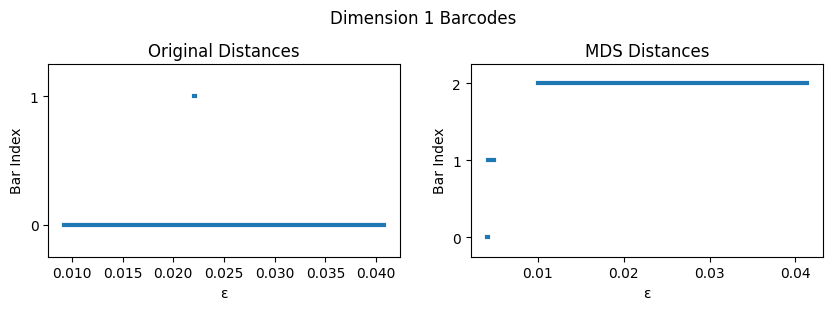

In [14]:
# plot barcodes 

fig, ax = plt.subplots(1, 2, figsize = (10, 2.5))

# plot barcodes 
for bar_iter in range(len(bc1)):
    ax[0].plot(bc1.iloc[bar_iter], [bar_iter, bar_iter], color = 'tab:blue', lw = 3)
for bar_iter in range(len(mds_bc1)):
    ax[1].plot(mds_bc1.iloc[bar_iter], [bar_iter, bar_iter], color = 'tab:blue', lw = 3)

# formatting 
ax[0].set_yticks([i for i in range(len(bc1))])
ax[1].set_yticks([i for i in range(len(mds_bc1))])
ax[0].set_ylim(-0.25, len(bc1)-0.75)
ax[1].set_ylim(-0.25, len(mds_bc1)-0.75)
for p in range(2):
    ax[p].set_xlabel('ε') 
    ax[p].set_ylabel('Bar Index') 
ax[0].set_title('Original Distances')  
ax[1].set_title('MDS Distances') 
plt.suptitle('Dimension 1 Barcodes', y = 1.1)

plt.show()